## Exercise in Photogrammetry I
## **Ex.4 : Binary Images**
### Hand out: xx.xx.xxxx 
### Submission: xx.xx.xxxx 
### Points: 30

## A. Binary Images and Connected Components *(18 points)*

In this task you will learn how to **convert grayscale** images to **binary** images by applying a certain **thresold**. Finally, based on the binary image we can **identify** which **components** are connected to compute the **number of objects** in the image.

**Tasks:**
1. Load the grayscale image ```shapes.png``` from disk and print its minimum and maximum value. Finally, visualize the grayscale image. *(0.5 points)*
2. Convert the grayscale image to a binary image by applying a threshold of $T=100$. Make sure that all pixels > T have an intensity value of 1 (foreground) and all other pixels have an intensity value of 0 (background). Print the minimum and maximum value of your converted image. Finally, visualize the binary image. *(1.5 points)*
3. In the lecture you discussed two algorithms to identify connected components in a binary image. Implement the *Connected Components for Grids* algorithm and apply it to the previous defined binary image by following each step outlined below:
    - Write a function called ```connected_components(binary_img, neighborhood)``` which computes the *components image* for either *N4 neighborhood* or *N8 neighborhood* **but** does not apply the *equivalence graph* (see *Algorithm 1 in lecture*). Do not use any external python functions which compute the *components image* for you.  *(8 points)*
      <br> **Hint:** Write functions to get the *N4* and *N8 neighborhood* since this operation will be used in other tasks as well
      
    - Apply your function to the binary image and visualize your result for *N4 neighborhood* and *N8 neighborhood*. *(2 points)*
    - Apply the *equivalence graph* to the *components image* and visualize your result for *N4 neighborhood* and *N8 neighborhood*. *(4 points)*
    - Finally, print the number of components in the binary image for *N4 neighborhood* and *N8 neighborhood*. If there is any difference explain why this is the case. *(2 points)*
    

In [3]:
# import all required modules
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
import numpy as np
from typing import Callable, List
import time

### A1

In [7]:
# Load the grayscale image
image = io.imread('images/shapes.png', as_gray=True)

In [9]:
# Print the minimum and maximum value of the grayscale image
print(image.min())
print(image.max())
print(image.dtype)

0
180
uint8


[]

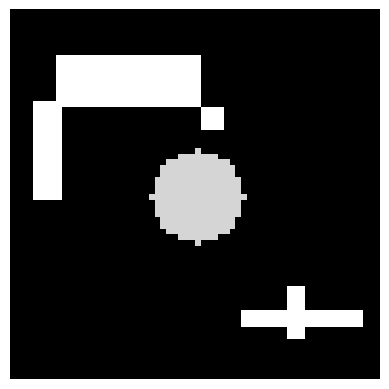

In [10]:
# Visualize the grayscale image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.plot()

### A2

In [11]:
# Convert the grayscale image to a binary image {0,1}

# Allocate.
binary_image = np.zeros(image.shape, dtype=np.uint8)

# Set value of 1 for every pixel of image8bytes that is bigger than 100.
binary_image[image > 100] = 1
        

In [12]:
# Print the minimum and maximum value of the binary image
print(binary_image.min())
print(binary_image.max())

0
1


[]

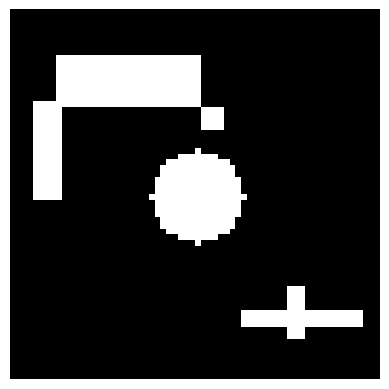

In [13]:
# Visualize the binary image
plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.plot()

### A3

In [14]:
# Write a function called connected_components(binary_img, neighborhood)

def getNeighbors(binary_image: np.ndarray, i: int, j: int, neighborhood_mode: bool, direction: bool, allow_empty: bool) -> np.ndarray:
    '''
    Finds all neighbors for pixel [i, j] on a given binary image, given N4 or N8 mode, given the direction.
    
    Parameters:
    - binary_image (np.ndarray): Source image.
    - i (int): Row.
    - j (int): Column.
    - neighborhood_mode (bool): 0 = N4, 1 = N8.
    - direction (bool): 0 = Upper left to bottom right, 1 = Bottom right to upper left.
    - allow_empty (bool): Allows for empty pixels to be considered neighbors.
    
    Returns:
    - np.ndarray: Array of tuples representing all valid neighbors for a given pixel.
    '''
    neighbors = []
    
    # Set primary directions based on direction.
    directions = [(0, -1), (-1, 0)] if direction == 0 else [(0, 1), (1, 0)]
    
    # Add diagonals based on neighborhood mode.
    if neighborhood_mode:
        directions.extend([(-1, -1), (-1, 1)] if direction == 0 else [(1, -1), (1, 1)])

    # Go through directions, look out for bounds.
    for di, dj in directions:
        ni, nj = i + di, j + dj
        if 0 <= ni < binary_image.shape[0] and 0 <= nj < binary_image.shape[1] and (allow_empty or binary_image[ni, nj] != 0):
            neighbors.append((ni, nj))

    return np.array(neighbors, dtype=int)

def getLabeledNeighbors(neighborhood_mask: np.ndarray, i: int, j: int, neighborhood_mode: bool) -> np.ndarray:
    '''
    Finds all labeled neighbors in neighborhood_mask at location [i, j] with a given mode.
    
    Parameters:
    - neighborhood_mask (np.ndarray): N x M matrix consisting of all currently labeled pixels.
    - i (int): Row index.
    - j (int): Column index.
    - neighborhood_mode (bool): 0 = N4, 1 = N8.
    
    Returns:
    - np.ndarray: 1D array of all neighbors for a given pixel.
    '''    
    # Initialize neighbors array.
    neighbors = np.array([], dtype=int)
    
    # Get the unlabeled neighbors.
    unlabeled_neighbors = getNeighbors(neighborhood_mask, i, j, neighborhood_mode, 0, 0)
    
    # Find labels in neighborhood_mask for the found unlabeled neighbors.
    if np.size(unlabeled_neighbors) > 0:
        neighbors = neighborhood_mask[unlabeled_neighbors[:, 0], unlabeled_neighbors[:, 1]]
            
    return neighbors

def update_equivalence_table(equivalence_table: list[set], component_index: int, neighbors: set) -> list[set]:
    '''
    Updates the given equivalence table.
    
    Parameters:
    - equivalence_table (list[set]): Current equivalence table.
    - component_index (int): Point of interest.
    - neighbors (set): Potentially new neighbors.
    
    Returns:
    - list[set]: Updated equivalence table.
    '''    
    
    # Find the index of the bin that contains component_index.
    index_of_matching_bin = next((i for i, s in enumerate(equivalence_table) if component_index in s), None)
    
    # Update equivalence table at that point.
    if index_of_matching_bin is not None:
        equivalence_table[index_of_matching_bin] |= neighbors
    else:
        equivalence_table.append(neighbors)
    
    return equivalence_table
            
def connected_components(binary_img: np.ndarray, neighborhood: bool) -> np.ndarray:
    '''
    Creates a neighborhood mask out of given binary image using N4 or N8 neighborhood.
    
    Parameters:
    - binary_image (np.ndarray): Given binary N x M image.
    - neighborhood_mode (bool): False - Uses N4, True - Uses N8.
    
    Returns:
    - Tuple[np.ndarray, Dict[int, List[int]]]: A tuple containing:
      - N x M neighborhood mask.
      - Equivalence table where keys are component indices, and values are lists of neighboring components.
    '''
    
    # Allocate the mask.
    neighborhood_mask = np.zeros(binary_image.shape, dtype=np.uint8)
    
    # Allocate the equivalence dictionary.
    equivalence_table = []
    
    # Initialize component counter.
    k = 0
    
    # https://www.youtube.com/watch?v=-F20DZhzbEs 32:19
    # Connected Components for Grids/Binary Images.
    
    # Loop through the binary_image.
    for i in range(binary_image.shape[0]):
        for j in range(binary_image.shape[1]):
            if binary_image[i][j] == 1:
                neighbors = getLabeledNeighbors(neighborhood_mask, i, j, neighborhood)
                if np.size(neighbors) == 0:
                    k += 1
                    neighborhood_mask[i, j] = k
                else:
                    min_neighbors = min(neighbors)
                    neighborhood_mask[i, j] = min_neighbors
                    if len(neighbors) > 1:
                        equivalence_table = update_equivalence_table(equivalence_table, min_neighbors, set(neighbors))
                        
    return neighborhood_mask, equivalence_table

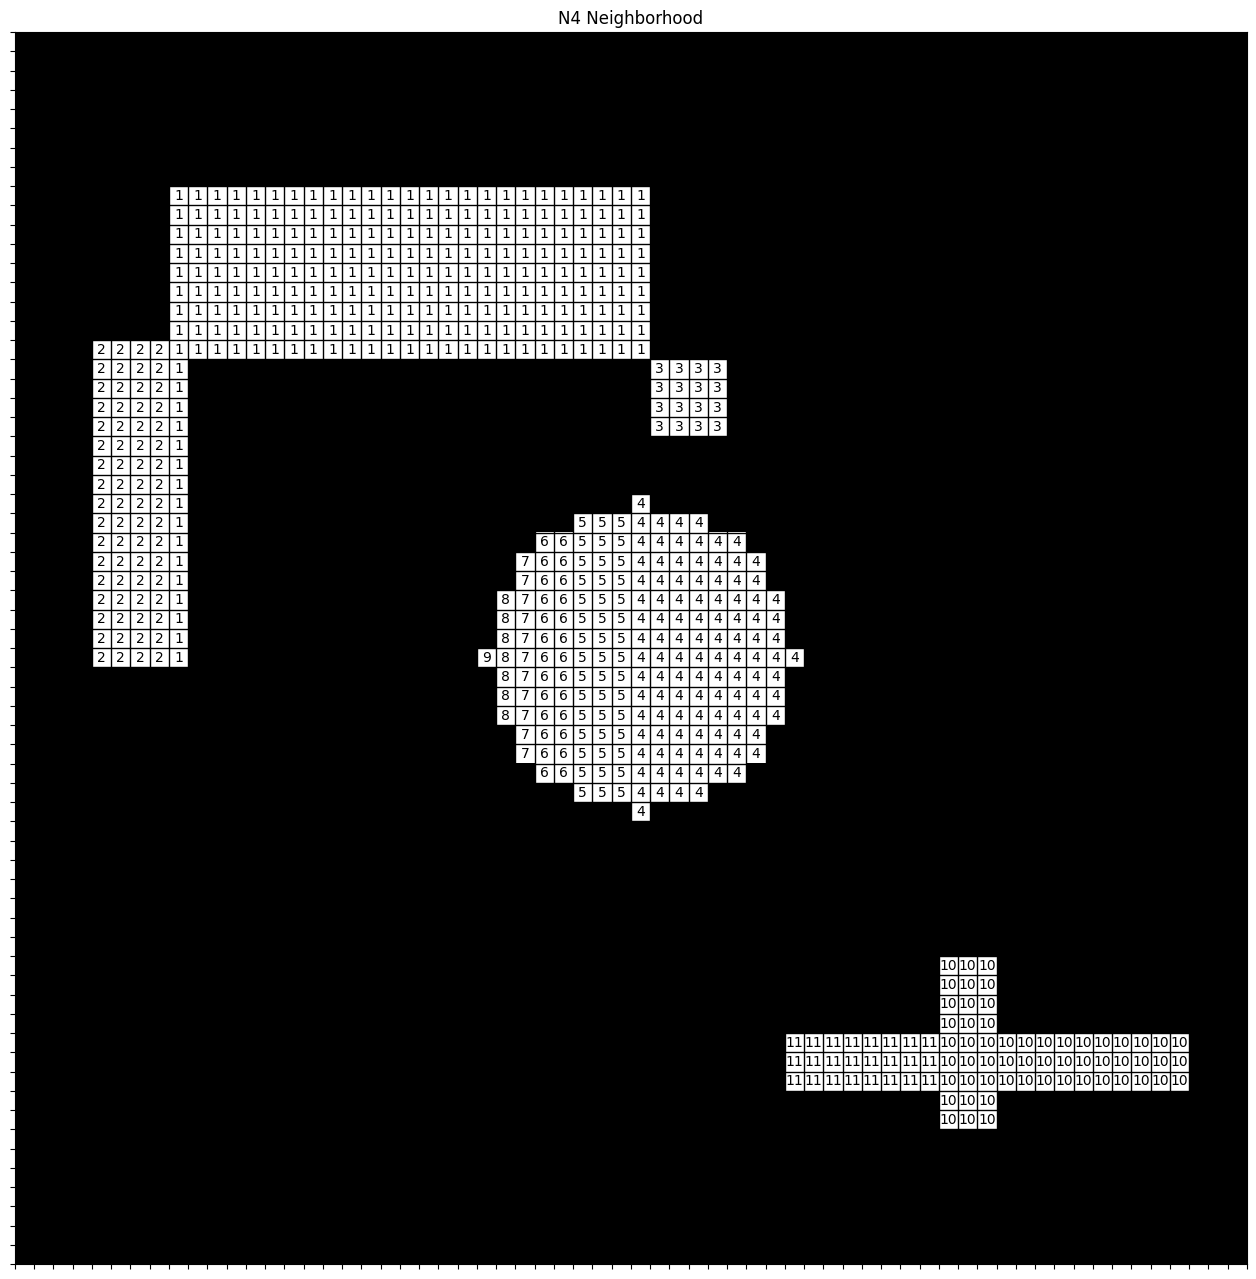

In [15]:
# Compute the components image with N4 Neighborhood and visualize your result
n4_neighbors, n4_equivalence_table = connected_components(binary_image, 0)

import math

fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(binary_image, cmap='gray')

ax.set_xticks(np.arange(-0.5, binary_image.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, binary_image.shape[0], 1), minor=False)
ax.grid(which='major', linestyle='-', linewidth=1, color='black')
ax.set_xticklabels([])
ax.set_yticklabels([])

for i in range(binary_image.shape[0]):
    for j in range(binary_image.shape[1]):
        value = n4_neighbors[i, j]
        
        if value > 0:
            ax.text(j, i, str(value), color='k', fontsize=10, ha='center', va='center')

plt.title('N4 Neighborhood')            
plt.show()

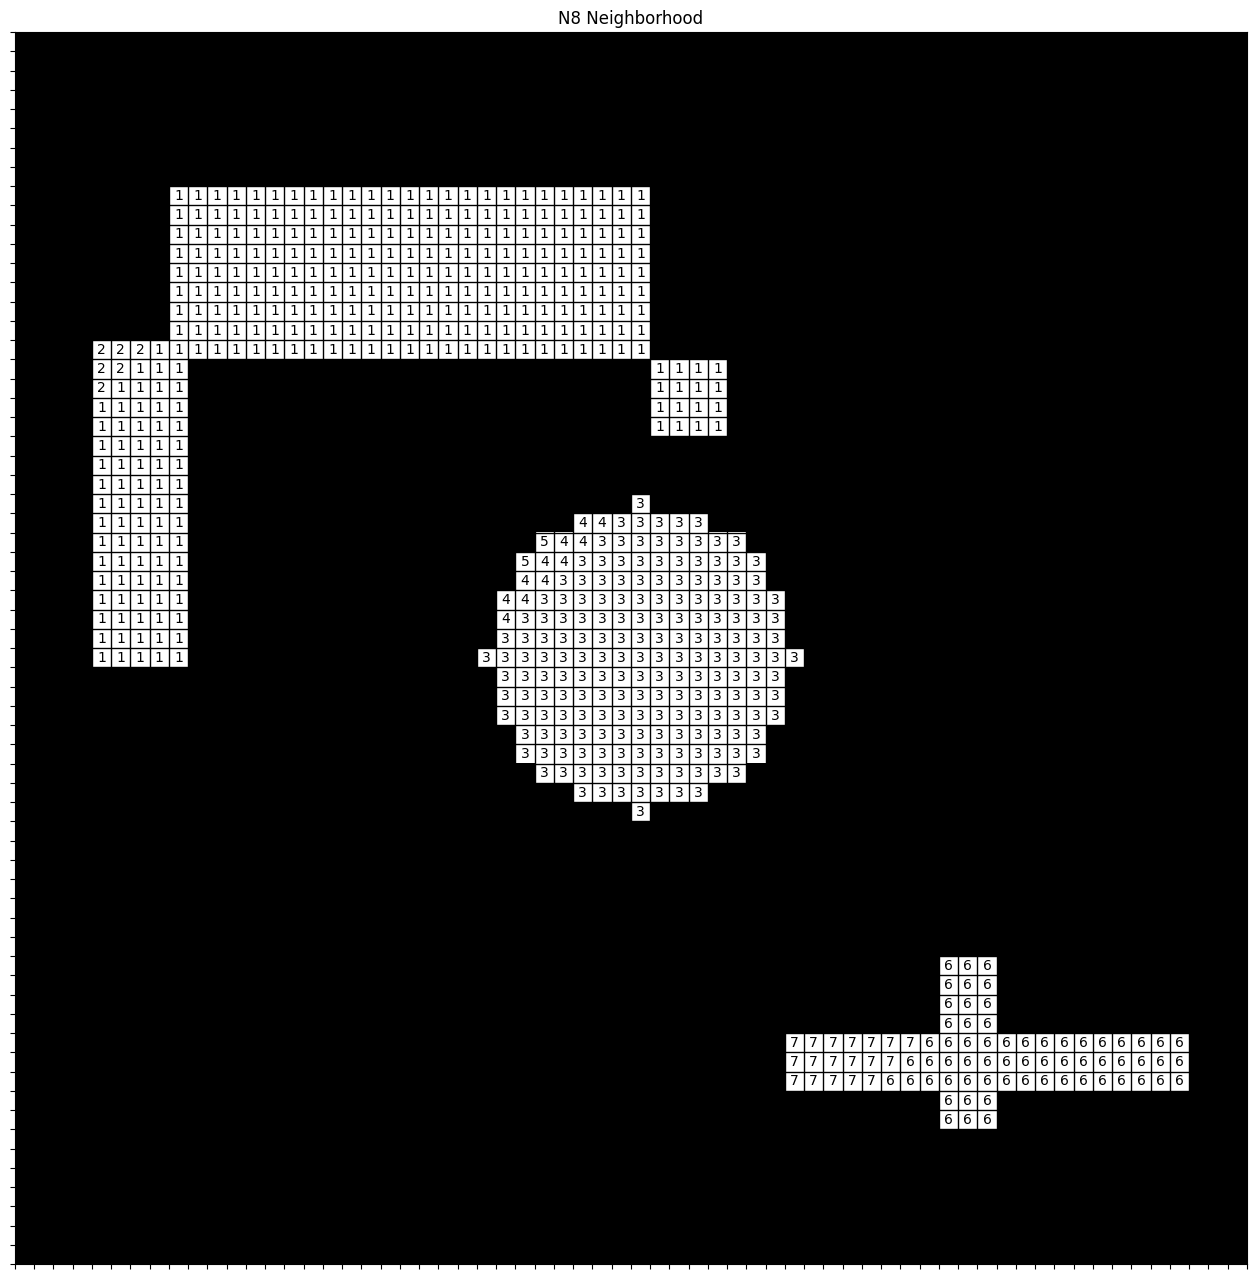

In [17]:
# Compute the components image with N8 Neighborhood and visualize your result
n8_neighbors, n8_equivalence_table = connected_components(binary_image, 1)

fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(binary_image, cmap='gray')

ax.set_xticks(np.arange(-0.5, binary_image.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, binary_image.shape[0], 1), minor=False)
ax.grid(which='major', linestyle='-', linewidth=1, color='black')
ax.set_xticklabels([])
ax.set_yticklabels([])

for i in range(binary_image.shape[0]):
    for j in range(binary_image.shape[1]):
        value = n8_neighbors[i, j]
        
        if value > 0:
            ax.text(j, i, str(value), color='k', fontsize=10, ha='center', va='center')

plt.title('N8 Neighborhood')
plt.show()

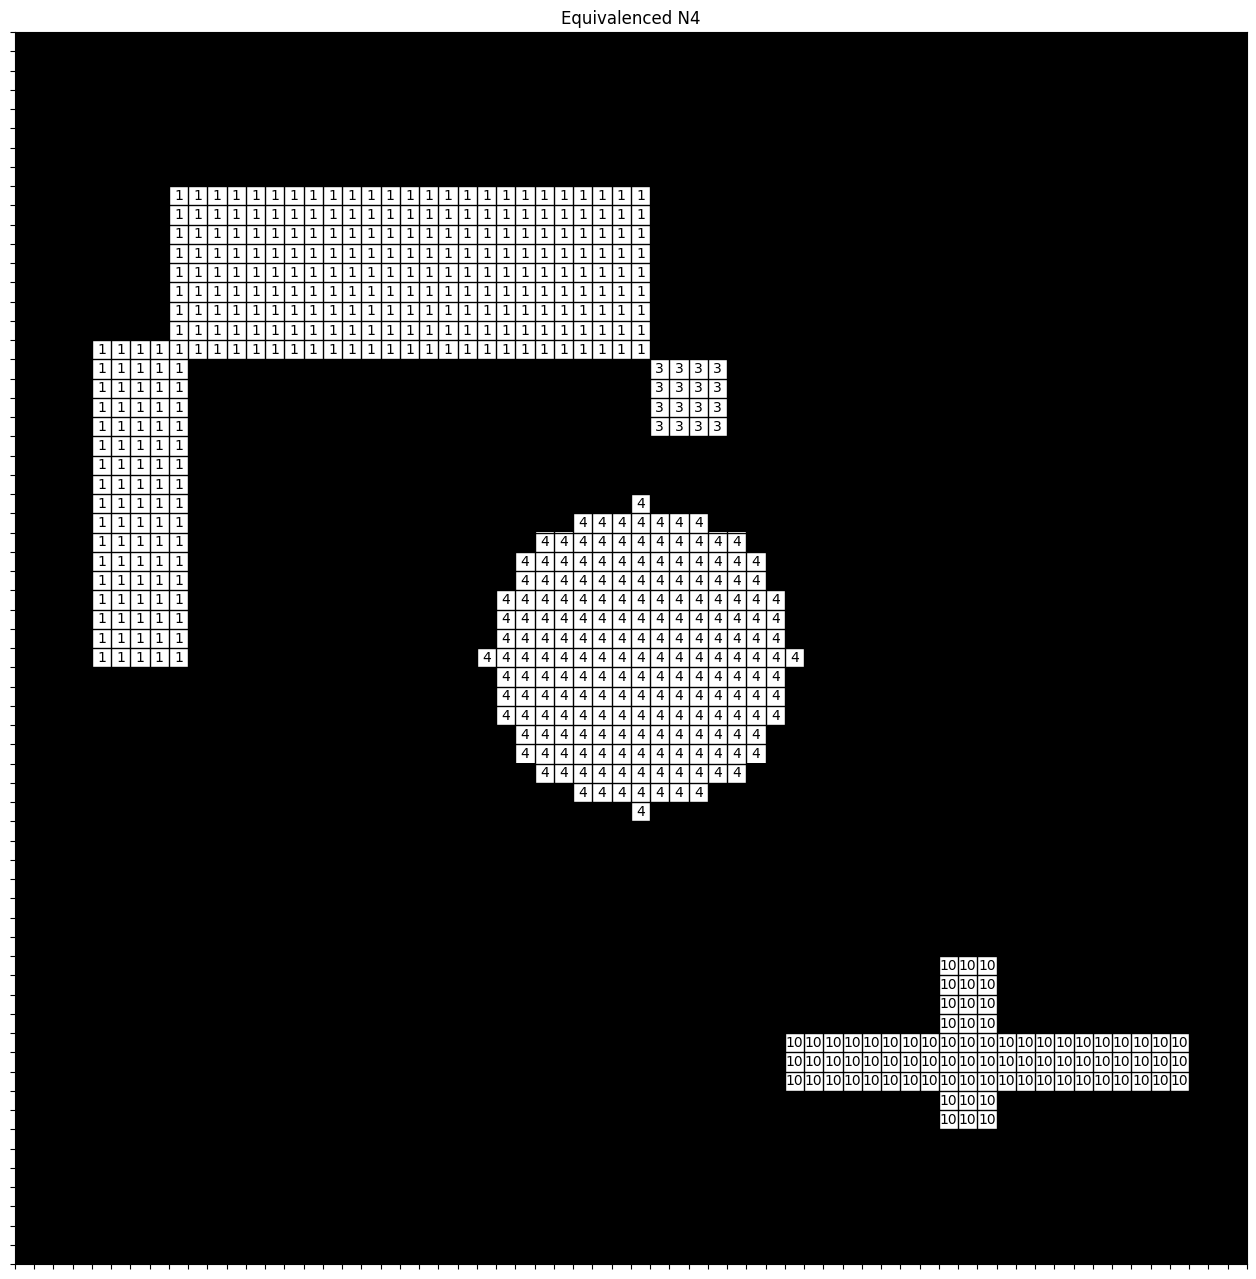

In [18]:
# Apply the equivalence graph to your components image with N4 Neighborhood and visualize your result
for i in range(n4_neighbors.shape[0]):
        for j in range(n4_neighbors.shape[1]):
            component_index = n4_neighbors[i][j]
            if component_index != 0:
                matching_bin = next((s for s in n4_equivalence_table if component_index in s), None)
                n4_neighbors[i][j] = min(matching_bin)
                    
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(binary_image, cmap='gray')

ax.set_xticks(np.arange(-0.5, n4_neighbors.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, n4_neighbors.shape[0], 1), minor=False)
ax.grid(which='major', linestyle='-', linewidth=1, color='black')
ax.set_xticklabels([])
ax.set_yticklabels([])

for i in range(n4_neighbors.shape[0]):
    for j in range(n4_neighbors.shape[1]):
        value = n4_neighbors[i, j]
        
        if value > 0:
            ax.text(j, i, str(value), color='k', fontsize=10, ha='center', va='center')

plt.title('Equivalenced N4')
plt.show()

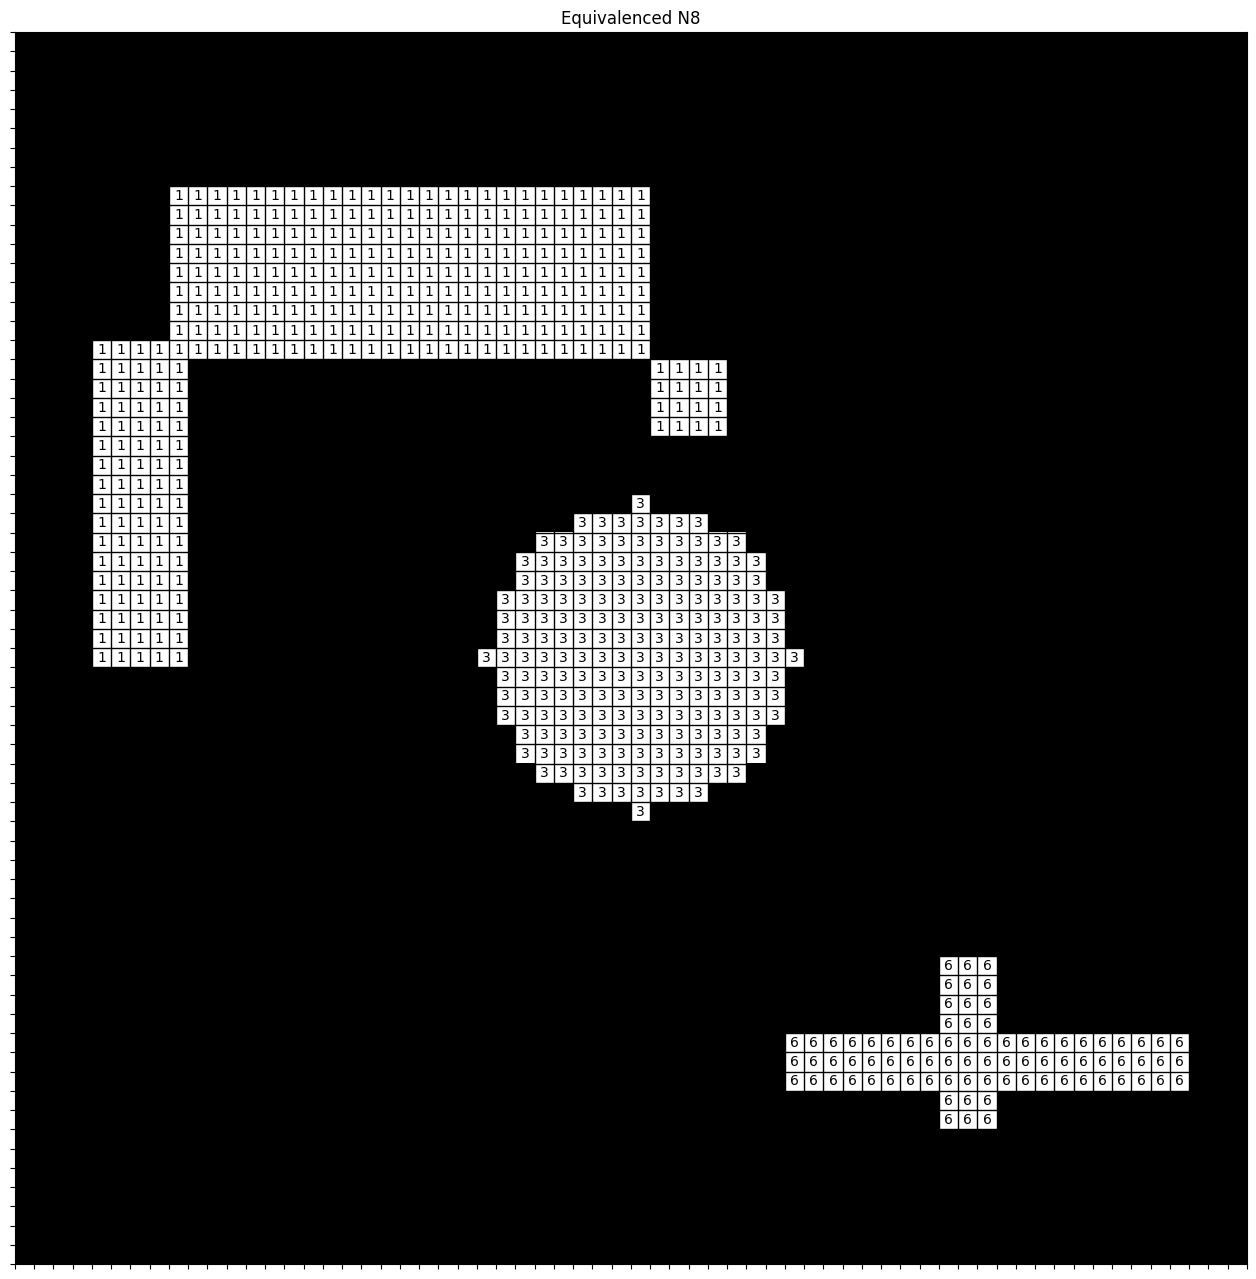

In [19]:
# Apply the equivalence graph to your components image with N8 Neighborhood and visualize your result

for i in range(n8_neighbors.shape[0]):
        for j in range(n8_neighbors.shape[1]):
            component_index = n8_neighbors[i][j]
            if component_index != 0:
                matching_bin = next((s for s in n8_equivalence_table if component_index in s), None)
                n8_neighbors[i][j] = min(matching_bin)
                    
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(binary_image, cmap='gray')

ax.set_xticks(np.arange(-0.5, n8_neighbors.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, n8_neighbors.shape[0], 1), minor=False)
ax.grid(which='major', linestyle='-', linewidth=1, color='black')
ax.set_xticklabels([])
ax.set_yticklabels([])

for i in range(n8_neighbors.shape[0]):
    for j in range(n8_neighbors.shape[1]):
        value = n8_neighbors[i, j]
        
        if value > 0:
            ax.text(j, i, str(value), color='k', fontsize=10, ha='center', va='center')

plt.title('Equivalenced N8')
plt.show()

In [20]:
# Print the number of components in the binary image for N4 Neighborhood and N8 Neighborhood
print(f'n4:{len(n4_equivalence_table)}')
print(f'n8:{len(n8_equivalence_table)}')

n4:4
n8:3


If there is any difference in the number of components explains why this is the case:<br>

- Using n8 gives us 1 less component, that's because we can connect diagonally.

## B. Morphological Operations and Distance Transformation *(12 points)*

In the lecture your discussed *Morphological Operators* to expand and shrink the foreground of binary images as well as the *Distance Transformation* to compute the distance from any pixel to the border of the components.

**Tasks:**
1. Implement the *Distance Transformation* algorithm and apply it to the previous defined binary image (*A2*) by following each step outlined below:
    - Write a function called ```distance_transformation(binary_img, neighborhood)``` which computes the *distance image* for either *N4 neighborhood* or *N8 neighborhood*. Do not use any external python functions which compute the *distance image* for you. *(5 points)*
    - Apply your function to the binary image and visualize your result for *N4 neighborhood* and *N8 neighborhood*. *(2 points)*
    
2. Apply a *Dilation* to the binary image by using the the ```skimage.morphology``` module ([link](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.dilation))
    - Follow the steps provided by the [example](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.dilation) to dilate the binary image *(2 points)*
    - Visualize your results and describe your observations *(1 point)*
    
3. Finally, apply the *Distance Transformation* with N4 neighborhood to the dilated binary image and visualize your result. *(2 points)*

### B1

In [21]:
# Write a function called distance_transformation(binary_img, neighborhood) to compute the distance matrix
def distance_transformation(binary_img: np.ndarray, neighborhood: bool) -> np.ndarray:
    '''
    Creates a distance map from a given binary image.

    Parameters:
    - binary_img (np.ndarray): Given binary image.
    - neighborhood (bool): Neighborhood mode 0 = N4, 1 = N8.

    Returns:
    - np.ndarray: Newly created distance map.
    '''
    
    # Allocate distance map.
    distance_map = np.zeros(binary_img.shape, dtype=np.uint8)

    # https://www.youtube.com/watch?v=-F20DZhzbEs 45:45
    # Distance Image.

    # Top-left to bottom-right pass.
    for i in range(binary_img.shape[0]):
        for j in range(binary_img.shape[1]):
            if binary_img[i][j] == 1:
                neighbors = getNeighbors(distance_map, i, j, neighborhood, 0, 1)
                dist = 1 + (np.min(distance_map[neighbors[:, 0], neighbors[:, 1]]) if len(neighbors) > 0 else 0) # Lowest neighbor + 1 if it exists.
                distance_map[i][j] = dist

    # Bottom-right to top-left pass.
    for i in range(binary_img.shape[0] - 1, -1, -1):
        for j in range(binary_img.shape[1] - 1, -1, -1):
            if binary_img[i][j] == 1:
                neighbors = getNeighbors(distance_map, i, j, neighborhood, 1, 1)
                dist = 1 + (np.min(distance_map[neighbors[:, 0], neighbors[:, 1]]) if len(neighbors) > 0 else 0) 
                distance_map[i][j] = min(dist, distance_map[i][j]) # Overwrite only if closer.
                    
    return distance_map

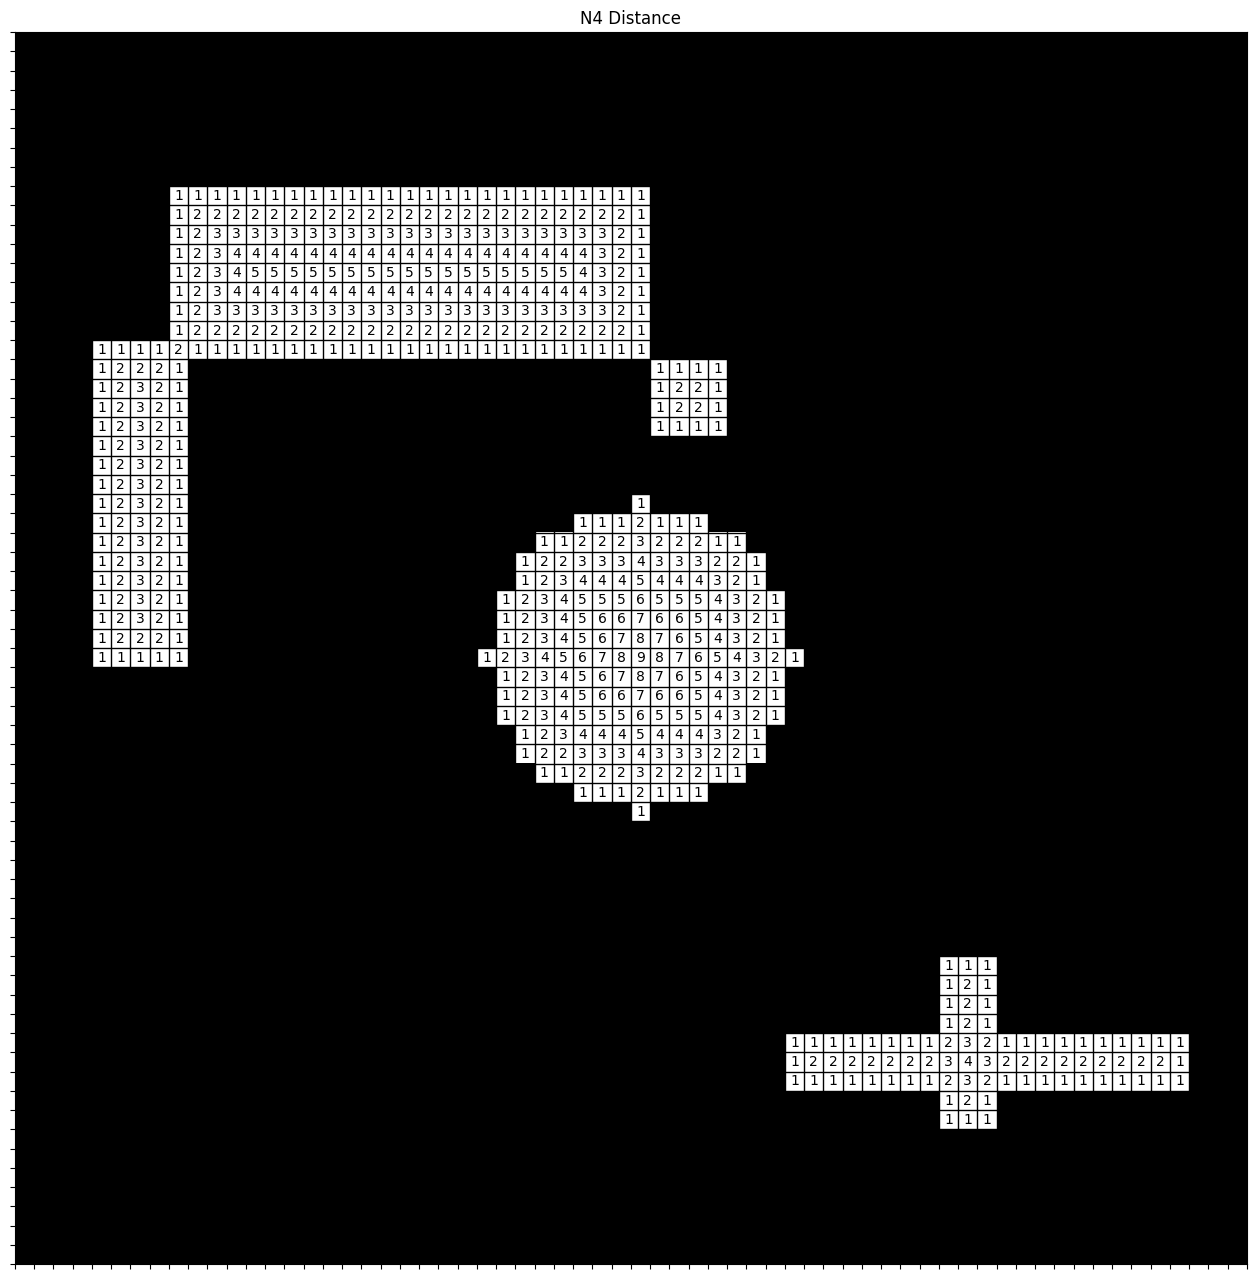

In [22]:
# Compute the distance matrix with N4 Neighborhood and visualize your result
n4_distance = distance_transformation(binary_image, 0)

fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(binary_image, cmap='gray')

ax.set_xticks(np.arange(-0.5, n4_distance.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, n4_distance.shape[0], 1), minor=False)
ax.grid(which='major', linestyle='-', linewidth=1, color='black')
ax.set_xticklabels([])
ax.set_yticklabels([])

for i in range(n4_distance.shape[0]):
    for j in range(n4_distance.shape[1]):
        value = n4_distance[i, j]
        
        if value > 0:
            ax.text(j, i, str(value), color='k', fontsize=10, ha='center', va='center')

plt.title('N4 Distance')            
plt.show()

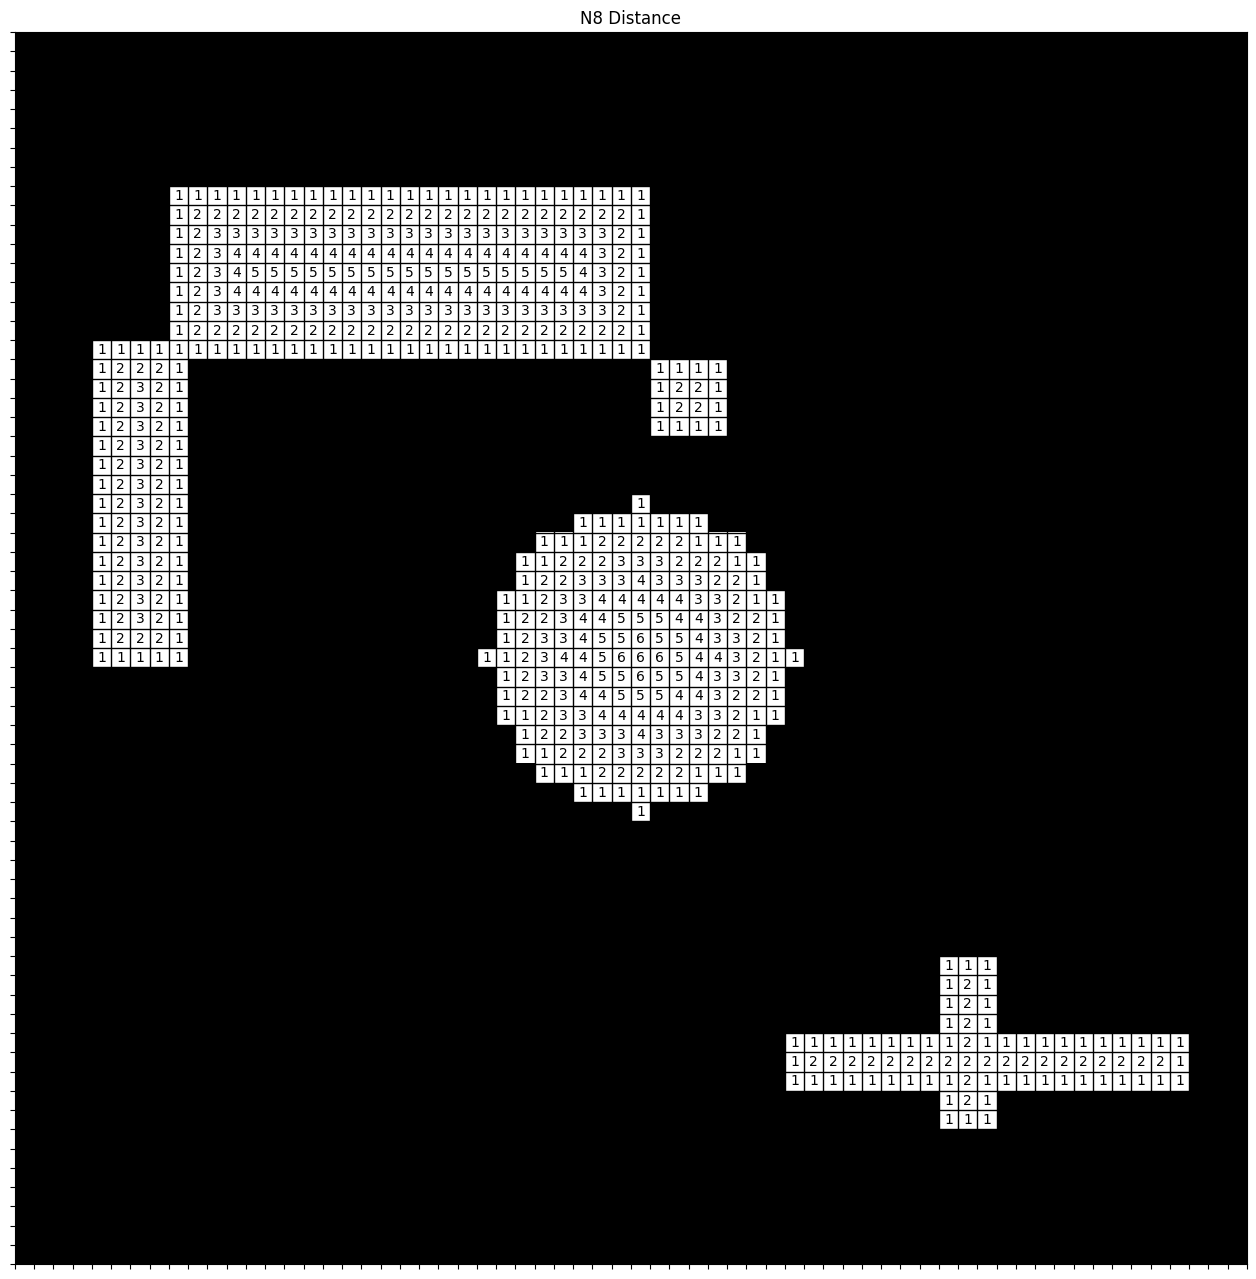

In [23]:
# Compute the distance matrix with N8 Neighborhood and visualize your result
n8_distance = distance_transformation(binary_image, 1)

fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(binary_image, cmap='gray')

ax.set_xticks(np.arange(-0.5, n8_distance.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, n8_distance.shape[0], 1), minor=False)
ax.grid(which='major', linestyle='-', linewidth=1, color='black')
ax.set_xticklabels([])
ax.set_yticklabels([])

for i in range(n8_distance.shape[0]):
    for j in range(n8_distance.shape[1]):
        value = n8_distance[i, j]
        
        if value > 0:
            ax.text(j, i, str(value), color='k', fontsize=10, ha='center', va='center')

plt.title('N8 Distance')            
plt.show()

### B2

In [24]:
# Apply a Dilation to the binary image
import skimage
from skimage.morphology import square

dilated = skimage.morphology.dilation(binary_image, square(3))

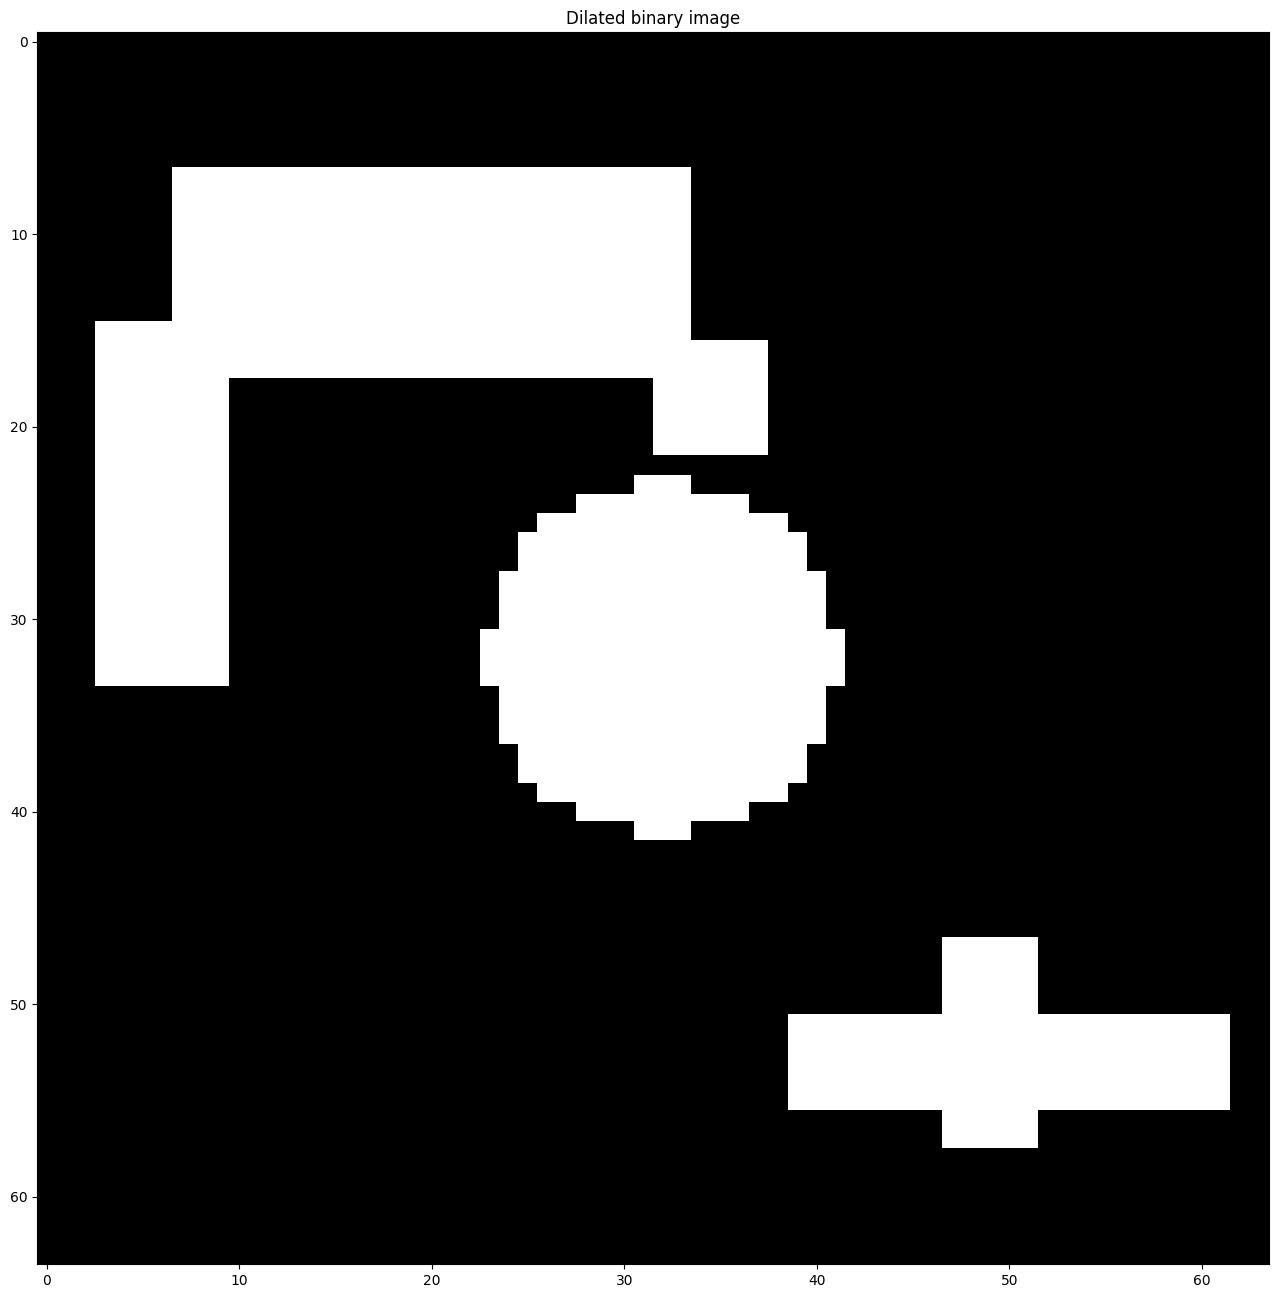

In [25]:
# Visualize the dilated binary image

fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(dilated, cmap='gray')
ax.set_title('Dilated binary image')

plt.show()

**Explain your observations here**
- It grew  up!
- The small part that was connected only diagonally got fully connected now.

### B3

In [26]:
# Compute the distance matrix with N4 Neighborhood of the dilated binary image
n4_dilated = distance_transformation(dilated, 0)

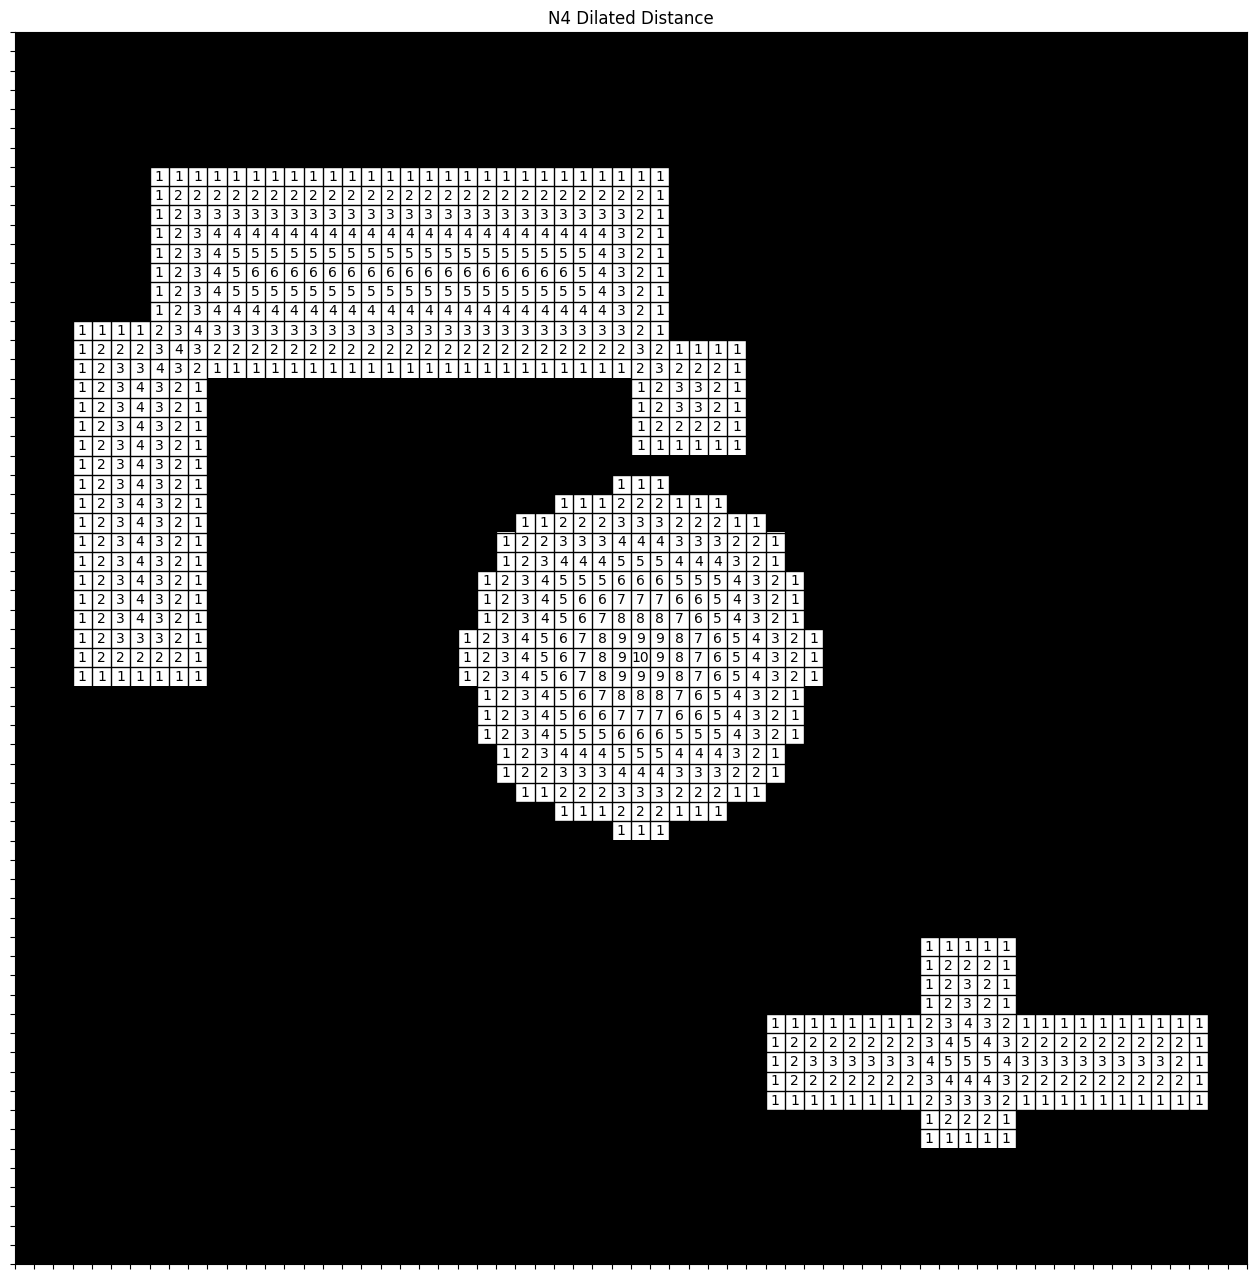

In [27]:
# Visualze the corresponding distance matrix
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(dilated, cmap='gray')

ax.set_xticks(np.arange(-0.5, n4_dilated.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, n4_dilated.shape[0], 1), minor=False)
ax.grid(which='major', linestyle='-', linewidth=1, color='black')
ax.set_xticklabels([])
ax.set_yticklabels([])

for i in range(n4_dilated.shape[0]):
    for j in range(n4_dilated.shape[1]):
        value = n4_dilated[i, j]
        
        if value > 0:
            ax.text(j, i, str(value), color='k', fontsize=10, ha='center', va='center')

plt.title('N4 Dilated Distance')            
plt.show()